# Part 02 - Epipolar Geometry (14)

- In this notebook, you'll embark on an exciting journey through the world of **epipolar geometry**. From understanding the fundamental matrix to visualizing epipolar lines and computing essential matrices, this exercise is packed with hands-on tasks that will deepen your understanding of 3D vision and camera geometry. Get ready to explore the mathematical backbone of stereo vision and its practical applications!

## 1 - Epipoles, Epipolar Lines and essential matrix

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
from utils import ReferenceFrame, Polygon, PrincipalAxis, Image, ImagePlane, \
    get_rotation_matrix, get_projection_matrix
%matplotlib ipympl

## 📝 Exercise 1: Understanding Epipolar Geometry and Essential Matrix (2 Points)

In this exercise, you will implement several key functions related to epipolar geometry and use them to visualize the relationship between two cameras and a 3D point. Specifically, you will:

1. **Implement Core Functions**:
    - `skew(x)`: Compute the skew-symmetric matrix of a vector.
    - `normalize_point(p)`: Dehomogenize a point (convert from homogeneous to Cartesian coordinates).
    - `essential_matrix(P1, P2)`: Compute the essential matrix given two camera projection matrices.
    - `lookat(eye, target, up)`: Compute the view matrix for a camera given its position, target, and up vector.

2. **Visualize the Scene (partially implemented)**:
    - Plot two cameras (purple and red) and a 3D point (green) in the 3D space.
    - Compute the essential matrix using the two camera matrices.
    - Use the essential matrix to calculate and plot the epipolar line as seen from the red camera.
    - Sample and plot points along the epipolar line.

---

### 🔧 Instructions

1. **Implement the Functions**:
    - Write the `skew(x)` function to compute the skew-symmetric matrix of a 3D vector `x`.
    - Write the `normalize_point(p)` function to convert a homogeneous point `p` into Cartesian coordinates.
    - Write the `essential_matrix(P1, P2)` function to compute the essential matrix using the relative rotation and translation between two cameras.
    - Write the `lookat(eye, target, up)` function to compute the view matrix for a camera.

2. **Set Up the Scene**:
    - Define two camera positions and orientations using the `lookat` function.
    - Define a 3D point in space.

3. **Compute the Essential Matrix**:
    - Use the `essential_matrix()` function to compute the essential matrix from the two camera matrices.

4. **Plot the Epipolar Line**:
    - Use the essential matrix to compute the epipolar line in the red camera's image plane.
    - Sample points along the epipolar line and plot them.

5. **Visualize the Results**:
    - Plot the 3D scene with the two cameras and the 3D point.
    - Plot the epipolar line and the sampled points in the red camera's image plane.

---

### 💡 Key Concepts

- **Skew-Symmetric Matrix**: Used to represent cross products in matrix form.
- **Essential Matrix**: Encodes the relative pose (rotation and translation) between two cameras.
- **Epipolar Line**: The projection of a 3D point in one camera's image plane onto the other camera's image plane.



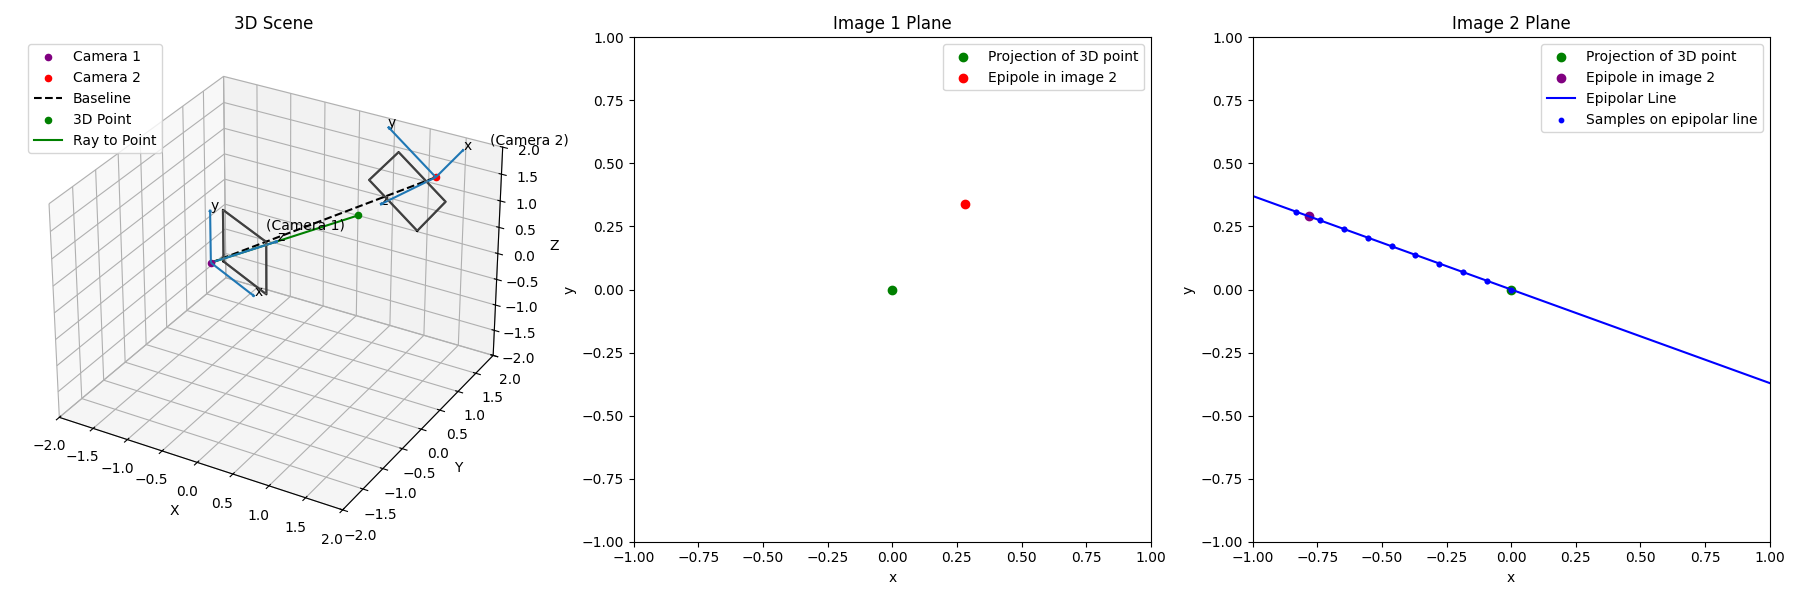

In [186]:
import numpy as np
import matplotlib.pyplot as plt
def skew(x):
    """Return the skew-symmetric matrix of a vector."""
    x_skew = np.array([[0, -x[2], x[1]],
                    [x[2], 0, -x[0]],
                    [-x[1], x[0], 0]])
    return x_skew

def normalize_point(p):
    if len(p.shape) == 1:
        points_nd_nonhomog = p[:-1]
        points_nd = points_nd_nonhomog / p[-1, np.newaxis]
    else:
        points_nd_nonhomog = p[:,:-1]
        points_nd = points_nd_nonhomog / p[:, -1, np.newaxis]
    return points_nd

def camera_center(P):
    """Compute camera center from projection matrix P (null space)."""
    U, S, Vt = np.linalg.svd(P)
    cam_cent = Vt[-1] / Vt[-1][-1]
    return cam_cent

def essential_matrix(P1, P2):
    """
    Compute the essential matrix from two projection matrices P1 and P2.

    Use rotation and translation matrices of each camera to 
    compute an essential matrix E = [t]_x * R, where [t]_x is the skew-symmetric
    matrix of the translation vector t, and R is the rotation matrix.

    Hint: R is the rotation matrix of the second camera with respect to the first camera, 
    and t is the translation vector of the second camera with respect to the first camera.
    """
    w_to_cam1, w_to_cam2 = np.eye(4), np.eye(4)
    w_to_cam1[:-1], w_to_cam2[:-1] = P1, P2
    cam2_to_cam1 = (w_to_cam1 @ np.linalg.inv(w_to_cam2))
    t = cam2_to_cam1[:3, 3]
    R = cam2_to_cam1[:3, :3]
    t_skew = skew(t)
    
    E = t_skew @ R
    return E.T

def lookat(eye, target, up):
    """Compute the view matrix for a camera."""
    # Write your code here
    z_cam = target-eye
    z_cam /= np.linalg.norm(z_cam)
    x_cam = np.cross(up, z_cam)
    x_cam /= np.linalg.norm(x_cam)
    y_cam = np.cross(z_cam, x_cam)
    y_cam /= np.linalg.norm(y_cam)

    R_cam_to_world = np.column_stack((y_cam, x_cam, z_cam))
    t_cam_to_world = eye

    T_cam_to_world = np.eye(4)
    T_cam_to_world[:3, :3] = R_cam_to_world
    T_cam_to_world[:3, 3] = t_cam_to_world
    
    T_world_to_cam = np.linalg.inv(T_cam_to_world)
    return T_world_to_cam[:-1]

# Set up the scene parameters
dx, dy, dz = np.eye(3) # World axes
X = np.array([0, 2, 0, 1])
IMAGE_HEIGTH = 1
IMAGE_WIDTH = 1
PX, PY = 0.5, 0.5
MX, MY = 1.0, 1.0
t1 = np.array([-1, 0, 0])  # Camera 1 translation
t2 = np.array([1, 2.2, 0.97])   # Camera 2 translation
FOCAL_LENGTH = 0.5


P1 = lookat(t1, normalize_point(X), up=np.array([1, 0, 0]))
P2 = lookat(t2, normalize_point(X), up=np.array([0, 1, 0]))

camera_frame_1 = ReferenceFrame(origin=t1, dx=P1[0, :3] / np.linalg.norm(P1[0, :3]), dy=P1[1, :3] / np.linalg.norm(P1[1, :3]), dz=P1[2, :3] / np.linalg.norm(P1[2, :3]), name="Camera 1")
camera_frame_2 = ReferenceFrame(origin=t2, dx=P2[0, :3] / np.linalg.norm(P2[0, :3]), dy=P2[1, :3] / np.linalg.norm(P2[1, :3]), dz=P2[2, :3] / np.linalg.norm(P2[2, :3]), name="Camera 2")


Z1 = PrincipalAxis(camera_center=camera_frame_1.origin, camera_dz=camera_frame_1.dz, f=FOCAL_LENGTH)
image_frame_1 = ReferenceFrame(origin=Z1.p - camera_frame_1.dx * PX - camera_frame_1.dy * PY,
    dx=P1[0, :3], dy=P1[1, :3], dz=P1[2, :3], name="Image")
image_plane_1 = ImagePlane(origin=image_frame_1.origin, dx=image_frame_1.dx, dy=image_frame_1.dy,
    heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH, mx=MX, my=MY)


Z_2 = PrincipalAxis(camera_center=camera_frame_2.origin, camera_dz=camera_frame_2.dz, f=FOCAL_LENGTH)
image_frame_2 = ReferenceFrame(origin=Z_2.p - camera_frame_2.dx * PX - camera_frame_2.dy * PY,
    dx=P2[0, :3], dy=P2[1, :3], dz=P2[2, :3], name="Image")
image_plane_2 = ImagePlane(origin=image_frame_2.origin, dx=image_frame_2.dx, dy=image_frame_2.dy,
    heigth=IMAGE_HEIGTH, width=IMAGE_WIDTH, mx=MX, my=MY)

# Compute projections of the 3D point onto the image planes (note, we don't use camera intrinsics for simplicity)
x1_h =  P1 @ X
x2_h =  P2 @ X
x1 = normalize_point(x1_h)
x2 = normalize_point(x2_h)

# Compute epipoles by projecting the camera centers onto the other image plane (note, we don't use camera intrinsics for simplicity))
C1 = camera_center(P1)
C2 = camera_center(P2)
e1 = normalize_point(P1 @ C2)
e2 = normalize_point(P2 @ C1)


# Compute fundamental matrix
F = essential_matrix(P1, P2)

# Compute epipolar line in image 2
l2 = F @ np.append(x1, 1)

# Sample 10 points along epipolar line in image 2
a, b, c = l2
dist = np.linalg.norm(x2 - e2) * np.sign(x1 - e1)
x_vals = np.linspace(0, dist, 10)
y_vals = -(a * x_vals + c) / b
# Generate points for the line defined by a, b, c
line_x_vals = np.asarray([-100, 100])
line_y_vals = -(a * line_x_vals + c) / b

# Plotting
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(131, projection='3d')

camera_frame_1.draw3d(head_length=0.05)
image_plane_1.draw3d()
camera_frame_2.draw3d(head_length=0.05)
image_plane_2.draw3d()

# Draw camera centers
ax.scatter(*C1[:3], color='purple', label='Camera 1')
ax.scatter(*C2[:3], color='red', label='Camera 2')

# Draw baseline
ax.plot([C1[0], C2[0]], [C1[1], C2[1]], [C1[2], C2[2]], 'k--', label='Baseline')

# Draw 3D point
ax.scatter(*X[:3], color='green', label='3D Point')

# Draw ray from camera 1 to 3D point
ax.plot([C1[0], X[0]], [C1[1], X[1]], [C1[2], X[2]], 'g-', label='Ray to Point')

ax.set_title("3D Scene")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.legend()

# Image 2 epipolar line
ax2 = fig.add_subplot(132)
ax2.set_title("Image 1 Plane")
ax2.scatter(*x1, color='green', label='Projection of 3D point')
ax2.scatter(*e1, color='red', label='Epipole in image 2')
ax2.set_xlim(-IMAGE_WIDTH, +IMAGE_WIDTH)
ax2.set_ylim(-IMAGE_HEIGTH, +IMAGE_HEIGTH)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()


# Image 2 epipolar line
ax3 = fig.add_subplot(133)
ax3.set_title("Image 2 Plane")
ax3.scatter(*x2, color='green', label='Projection of 3D point')
ax3.scatter(*e2, color='purple', label='Epipole in image 2')
ax3.plot(line_x_vals, line_y_vals, 'b-', label='Epipolar Line')
ax3.scatter(x_vals, y_vals, color='blue', s=10, label='Samples on epipolar line')
ax3.set_xlim(-IMAGE_WIDTH, +IMAGE_WIDTH)
ax3.set_ylim(-IMAGE_HEIGTH, +IMAGE_HEIGTH)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.legend()
plt.tight_layout()
plt.show()


#### **Expected Result**:<br>
![Correspondences](../data/epipolar_line_plot.png)

---

# 👁️‍🗨️ 2 - View Morphing

## Introduction

In this exercise, you'll implement the core steps of **view morphing** — a technique that generates **intermediate views** between two images taken from different camera positions. The goal is to simulate a **virtual camera** that moves smoothly between two real ones, creating the illusion of motion and depth from static images.

You'll be working with two images of the **same face captured from different viewpoints**, and progressively transforming them into a smooth morph.

---

## 🔧 What You'll Do – Step-by-Step

1. **Feature Detection**  
   Extract **facial keypoints** from the two input images using a face landmark detector.

2. **Epipolar Geometry & Rectification**  
   Compute the **fundamental matrix** to understand how the two views are related. Then, use it to **rectify** the images — aligning them so that corresponding points lie on the same scanlines.

3. **Morphing**  
   Interpolate between the two **rectified images** to synthesize an intermediate view.

4. **Postwarping**  
   Apply a final **postwarp** to bring the morphed image back to a natural-looking perspective.

---

## 🛠️ Tools You Can Use

You’re encouraged to use `OpenCV` to simplify the implementation. At each step, we’ll suggest helpful functions — such as:

- `cv2.findFundamentalMat` for estimating geometry  
- `cv2.stereoRectifyUncalibrated` and `cv2.warpPerspective` for rectification and warping  

However, the real objective is not just to run the pipeline, but to **understand the geometry** powering each step.

---

## 🎯 Learning Goals

By the end of the exercise, you'll:

- Understand **epipolar geometry** and **image rectification**
- See how **keypoint correspondences** drive morphing
- Get hands-on practice with **view synthesis** using real images

---

#### Helper Functions and Image loading

In [187]:
# Imports and provided functions

import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/shape_predictor_68_face_landmarks.dat")

def get_face_keypoints(image):
    """Detect face keypoints using dlib."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None

    shape = predictor(gray, faces[0])
    points = np.array([[p.x, p.y] for p in shape.parts()])
    return points


# 1. Load images
# img1 = cv2.imread('../data/einstein1.jpg', cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread('../data/einstein3.jpg', cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('../data/face_1.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('../data/face_2.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)



if img1.ndim == 2:
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
if img2.ndim == 2:
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

## 🔍 Step 1: Detect Face Keypoints and Find Correspondences (2 Points)

The first step of view morphing is to understand how the two input images relate to each other. To do this, we need to **identify matching points** — that is, locations in both images that correspond to the same physical point on the face.

In this case, we'll use a **facial keypoint detector** to extract corresponding landmarks from both images (such as the eyes, nose tip, mouth corners, etc.). These landmarks will serve as reliable and semantically meaningful matches.

Why is this important?  
👉 Because **epipolar geometry** — the relationship between the two views — is entirely based on how 3D points are projected into both images. Without good correspondences, we can't compute the fundamental matrix, nor can we align or morph the views.

---

### 🧪 Instructions

We provide you with a helper function `get_face_keypoints()` that returns a list of 2D facial landmark coordinates from a given image.

Complete the code to extract them and visualize the inlier correspondences. You may also need `cv2.KeyPoint` and `cv2.drawMatches()`

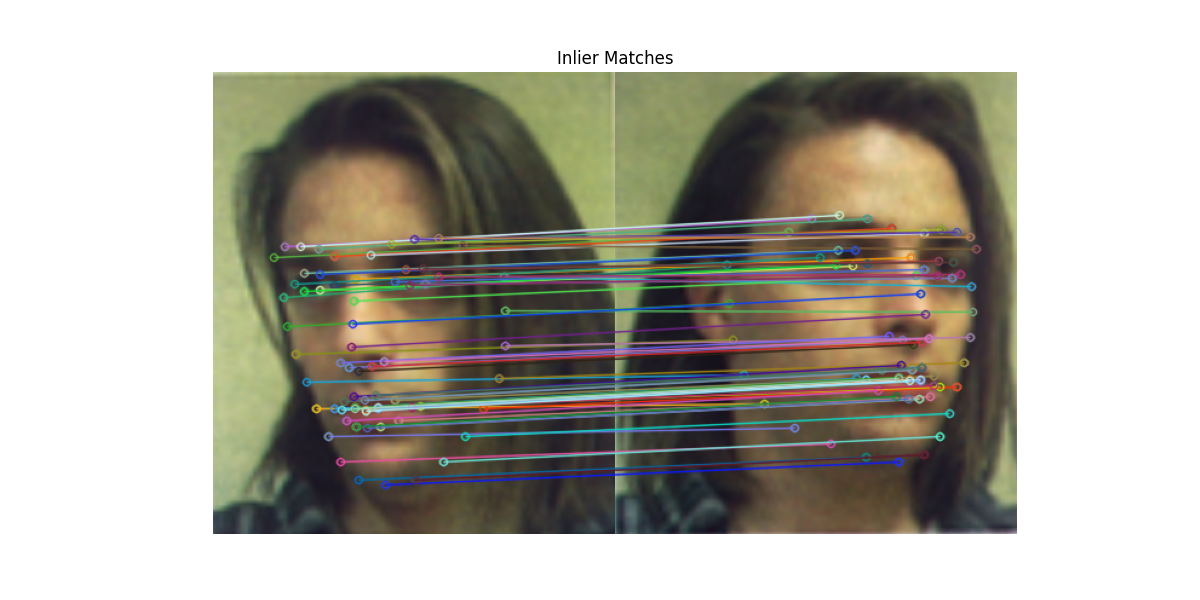

In [ ]:

# Get the face keypoints
points_1 = get_face_keypoints(img1)
points_2 = get_face_keypoints(img2)


# Make sure both detected
keypoints1 = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=1) for pt in points_1]
keypoints2 = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=1) for pt in points_2]

# Create DMatch objects for the inliers
matches = [cv2.DMatch(i, i, 0) for i in range(len(points_1))]

# Draw the matches using cv2.drawMatches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)

plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title("Inlier Matches")
plt.axis('off')
plt.show()

#### **Result** (It may  a little bit from run to run):<br>
![Correspondences](../data/corresp.png)

---

### 🔧 Step 2: Estimate the Geometry and Rectify the Views (4 Points)

In this step, you’ll bring in epipolar geometry to align the two views, preparing them for interpolation.

You will:

1. **Estimate the Fundamental Matrix** using the matched keypoints.  
   Use `cv2.findFundamentalMat()` with the `RANSAC` method to ensure robustness to mismatches and noise.

2. **Filter Inlier Matches**  
   Keep only the correspondences that are consistent with the estimated epipolar geometry (i.e., the inliers).  
   This is essential to avoid incorrect geometry in the next steps.
   To do so, use the mask returned by cv2.fundFundamentalMat() to filter valid points.

3. **Compute Rectification Homographies**  
   Use `cv2.stereoRectifyUncalibrated()` to estimate two homographies—`H1` and `H2`—that warp the input images so that:
   - Epipolar lines become horizontal.
   - Corresponding points lie on the same scanlines.

4. **Warp the Images**  
   Apply the rectification homographies to the input images using `cv2.warpPerspective()`.

5. **Rectify the Keypoints**  
   Implement a small helper function `rectify_points()` to warp the keypoints with their respective homographies, so they can be used in the interpolation step.

6. **Visualize the Rectified Matches**  
   Display the warped images side by side, and draw lines connecting the rectified keypoints.  
   If the rectification worked correctly, all lines should be approximately horizontal!

---

You can use OpenCV functions to help you implement most of this step, but you'll need to write the `rectify_points()` function yourself. It simply applies a homography to a list of 2D points and converts the results back to Cartesian coordinates.

This step prepares the input images for interpolation by aligning their geometry—so make sure it looks right before moving on!


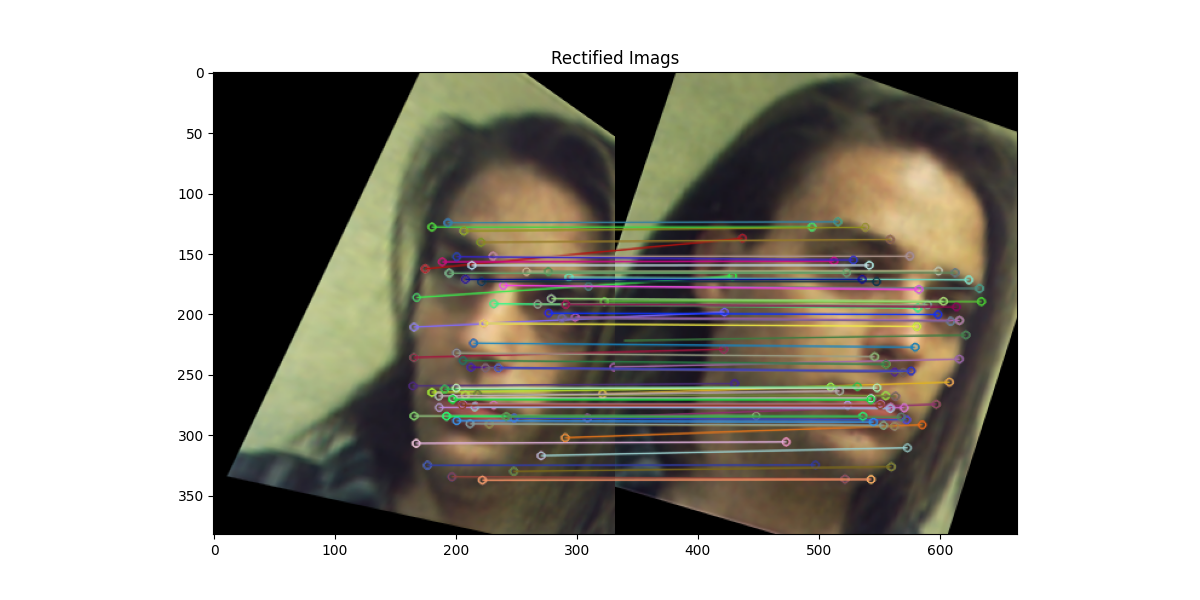

In [ ]:
# Assuming pts1, pts2 are inlier correspondences used to estimate F
h, w = img1.shape[:2]
img_size = (w,h)

# Find fundamental matrix using cv2 and RANSAC
F, mask = cv2.findFundamentalMat(points_1, points_2, cv2.RANSAC)

# Filter inliers
pts1_inliers = points_1[mask.ravel() == 1]
pts2_inliers = points_2[mask.ravel() == 1]

# Compute rectification homographies with cv2.stereoRectifyUncalibrated
success, H1, H2 = cv2.stereoRectifyUncalibrated(points_1, points_2, F, img_size)

assert success, "Stereo rectification failed"

# Warp images using cv2.warpPerspective
img1_rect = cv2.warpPerspective(img1, H1, img_size)
img2_rect = cv2.warpPerspective(img2, H2, img_size)

def rectify_points(pts, H):
    """
    Apply an homografy H to a list of points (Nx2). 
    
    Check cv2.convertPointsToHomogeneous documentation.
    """
    pts_homog = cv2.convertPointsToHomogeneous(pts)[:,0,:]
    rect_pts = pts_homog @ H.T
    rect_pts = rect_pts[:,:-1] / rect_pts[:,-1, np.newaxis]
    return rect_pts

pts1_rect = rectify_points(points_1, H1)
pts2_rect = rectify_points(points_2, H2)

# Convert points to cv2.KeyPoint objects
keypoints_rect_1 = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=1) for pt in pts1_rect]
keypoints_rect_2 = [cv2.KeyPoint(x=float(pt[0]), y=float(pt[1]), size=1) for pt in pts2_rect]

matches = [cv2.DMatch(i, i, 0) for i in range(len(pts1_rect))]

# Draw the matches
img_matches = cv2.drawMatches(img1_rect, keypoints_rect_1, img2_rect, keypoints_rect_2, matches, None)

# Show result
plt.figure(figsize=(12, 6))
plt.imshow(img_matches, cmap='gray')
plt.title("Rectified Imags")
plt.show()

#### **Result** (It may  a little bit from run to run):<br>
![Correspondences](../data/corresp_warped.png)

### 🎨 Step 3: Morph the View via Sparse Point Interpolation (4 Points)

Now that you have the two rectified images and a set of corresponding points across them, it's time to blend the two point sets into a new one. The goal of this step is to simulate a virtual camera placed **somewhere between** the original cameras.

Since we only have **sparse correspondences** (keypoints), the best we can do at this stage is to morph only those points and their immediate surroundings. To morph the entire image, we would need **dense correspondences**, which involve finding a mapping for every pixel between the two images. This will be addressed later in the exercise when we will exploit triangulation to find correspondencies.

To morph our keypoints, you have to interpolate both:

- The **positions** of the keypoints (so that each point smoothly moves from the left image to the right one).
- The **pixel values** at each keypoint (so the appearance blends as the geometry morphs).

#### 👇 What You’ll Do

You’ll implement a function called `morph_view()` that performs this interpolation.

Here’s how it works conceptually:

1. **Interpolate the Point Locations:**  
   For a given value of $\alpha \in [0, 1]$, we compute an interpolated point as:  
   $\text{pts\_interp} = (1 - \alpha) * \text{pts1} + \alpha * \text{pts2}$  
   When $\alpha=0$, we stay at the left view; when $\alpha=1$, we get the right view.

2. **Sample Pixel Values:**  
   The, using the same alpha, interpolate the color at that location in both input images (using bilinear sampling).

3. **Paint the Result:**  
   We then paste the interpolated color at the interpolated location in the output image.

💡 Note: This is a **sparse morphing**, which only fills pixels around the interpolated keypoints. In the next steps, you could try to densify this morph using triangulation - but for now, this is a great first approximation.

You should implement the `morph_view()` function yourself. The code that calls this function and displays the morphed frames will be provided.


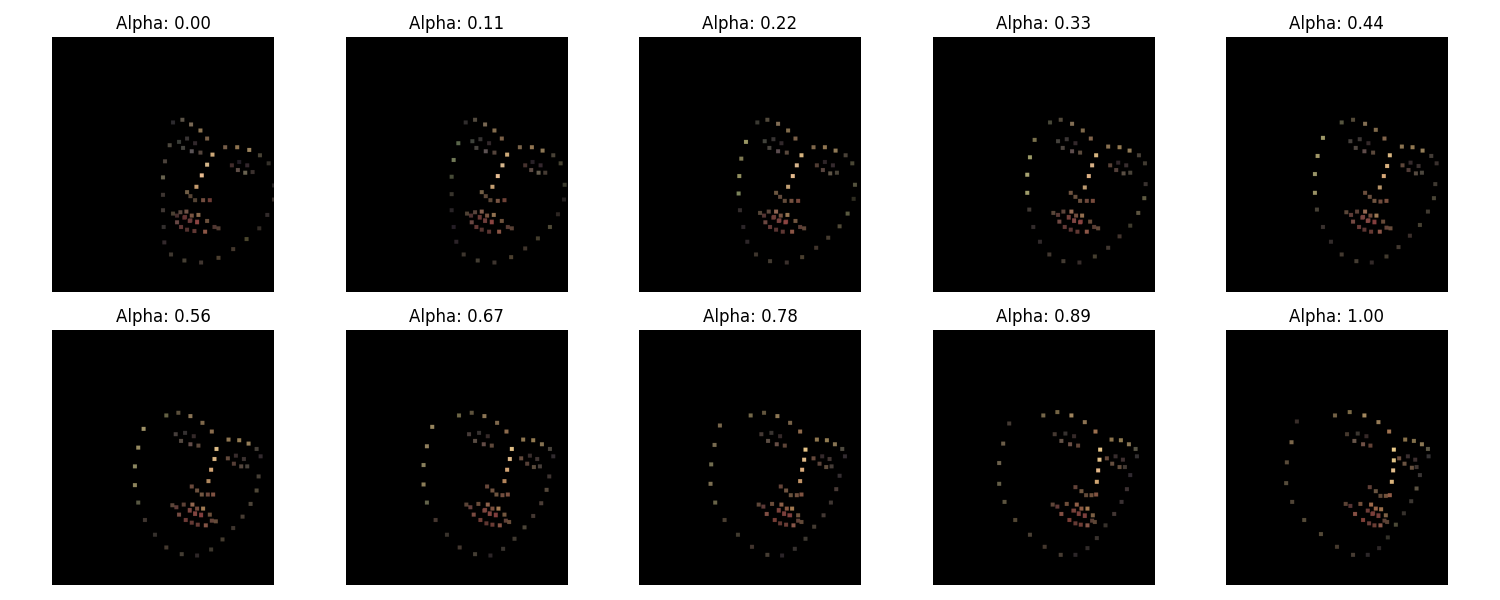

In [260]:
def morph_view(img1, img2, pts1, pts2, alpha):
    """
    Interpolates between two rectified images using corresponding points.
    """
    pts1 = np.clip(pts1, [0, 0], [img1.shape[1] - 1, img1.shape[0] - 1])
    pts2 = np.clip(pts2, [0, 0], [img2.shape[1] - 1, img2.shape[0] - 1])
    pts_interp = np.round((1 - alpha) * pts1 + alpha * pts2).astype(int)
    clr_interp = (1 - alpha) * img1[pts_interp[:, 1], pts_interp[:, 0]] + alpha * img2[pts_interp[:, 1], pts_interp[:, 0]]
    output_image = np.zeros_like(img1)
    output_image[pts_interp[:, 1], pts_interp[:, 0]] = clr_interp
    kern_size = 6
    return cv2.dilate(output_image, kernel=np.ones((kern_size, kern_size)))

frames = []
for a in np.linspace(0, 1, 10):
    frame = morph_view(img1_rect, img2_rect, pts1_rect, pts2_rect, alpha=a)
    frames.append(frame)

# Display the morphed images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(frames[i])
    ax.axis('off')
    ax.set_title(f"Alpha: {i/9:.2f}")
plt.tight_layout()
plt.show()

#### **Result** (It may  a little bit from run to run):<br>
![Correspondences](../data/morphed_keypoints.png)

### 🧩 Step 4: Dense Reconstruction and Face Morphing with Delaunay Triangulation

In this step, we use **Delaunay triangulation** to achieve a dense reconstruction of the face and morph the entire face between the two images. This section does not contain missing code to compelte. However, you should read and understand the provided code, and then answer some questions.

Delaunay triangulation divides the set of corresponding points into triangles, ensuring that no point lies inside the circumcircle of any triangle. This property makes it ideal for warping and morphing tasks.

![Delaunay Triangulation 1](../data/delan_triang_1.png)
![Delaunay Triangulation 2](../data/delan_triang_2.png)

---

### 📝 Questions to Consider

1. **Why is Delaunay triangulation used for this task?**  
    Becasuse we only have the epipolar lines (and thus trajectories) for the corresponding points. These are sparse yet we would like to interpolate between images for the whole face. Delaunau triangulation assists us by getting the points closest to the correspondence points which should interpolate in the same manner as the correspondence point.

2. **What role does the affine transformation play in morphing?**  
    While it is easy to interpolate between two corresponding points doing so for whole images or patches of images (triangles in this case) requires an affine transformation so more points can be interpolated from the view of image 0 to that of image 1 in an efficient way.

3. **How does the `alpha` parameter affect the output?**  
    When alpha=0 the image is the resulting image is the same as image 0 while when it is 1 we get image 1. For values in between the image is interpolated between image 0 and 1 according to its epipolar lines.

4. **What would happen if the triangulation was not consistent between the two images (like the one in the pictures above)?**  
    If there is a different number of triangles then there would be triangles in image 0 which have no pair in image 1 thus we'd need to discard the lonely triangle but this would result in an empty patch. If the vertices are not corresponding to the same face region we would end up morphing between disparate regions. In the latter case we may, for instance, end up morphing between an eye and mouth. Not desirable at all.

---

This code provides a complete pipeline for dense face morphing, but understanding the underlying concepts is key to appreciating how it works!

In [ ]:
from scipy.spatial import Delaunay

def get_delaunay_triangles(points, size=None):
    """
    Run Delaunay and return the triangles.
    """
    subdiv = Delaunay(points)
    return subdiv.simplices  # array (M, 3) of indices

def affine_transform(src, dst):
    """
    Runs affine transformation 2x3 from src -> dst.
    src and dst must be 3x2 (triangle vertices).
    """
    return cv2.getAffineTransform(np.float32(src), np.float32(dst))

def morph_triangle(img1, img2, out_img, tri1, tri2, tri, alpha):
    """
    Warp and interpolate a triangle from img1 and img2 to out_img.
    """
    # Bounding box
    r = cv2.boundingRect(np.float32([tri]))
    x, y, w, h = r
    if w == 0 or h == 0:
        return

    # Offset points
    tri1_rect = [(p[0]-x, p[1]-y) for p in tri1]
    tri2_rect = [(p[0]-x, p[1]-y) for p in tri2]
    tri_rect = [(p[0]-x, p[1]-y) for p in tri]

    # Mask
    mask = np.zeros((h, w, 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri_rect), (1.0, 1.0, 1.0), 16, 0)

    # Warp triangle 1 and 2
    img1_crop = img1[y:y+h, x:x+w]
    img2_crop = img2[y:y+h, x:x+w]

    warp1 = cv2.warpAffine(img1_crop, affine_transform(tri1_rect, tri_rect), (w, h))
    warp2 = cv2.warpAffine(img2_crop, affine_transform(tri2_rect, tri_rect), (w, h))

    img_morphed = (1 - alpha) * warp1 + alpha * warp2

    # Write on out_img
    if x + w > out_img.shape[1]:
        w = out_img.shape[1] - x
        mask = mask[:h, :w]
        img_morphed = img_morphed[:h, :w]
    if y + h > out_img.shape[0]:
        h = out_img.shape[0] - y
        mask = mask[:h, :w]
        img_morphed = img_morphed[:h, :w]
        
    out_img[y:y+h, x:x+w] = out_img[y:y+h, x:x+w] * (1 - mask) + img_morphed * mask

def morph_image(img1, img2, pts1, pts2, alpha):
    img1 = np.float32(img1)
    img2 = np.float32(img2)
    h, w = img1.shape[:2]
    out_img = np.zeros((h, w, 3), dtype=np.float32)

    pts = (1 - alpha) * pts1 + alpha * pts2
    triangles = get_delaunay_triangles(pts, (w, h))
    
    for tri in triangles:
        a, b, c = tri
        morph_triangle(
            img1, img2, out_img,
            pts1[[a, b, c]], pts2[[a, b, c]], pts[[a, b, c]],
            alpha
        )

    return np.clip(out_img, 0, 255).astype(np.uint8)

In [ ]:

def transform_points(points, H_inv):
    z = np.ones(shape=(1, len(points)))
    points = np.concatenate((points, z.T), axis=1)
    points_trans = np.matmul(H_inv, points.T)
    return np.array(points_trans.T).astype(np.uint8)


def mapDelaunay(triangles_A, points_A, points_B, points_C):
    # Using delauny triangle map for one image, get triangles for the two other images as well
    triangles_B = []
    triangles_C = []
    points_A = np.uint8(points_A)
    triangles_A = np.uint8(triangles_A)
    for tri in triangles_A:
        tri_B = []
        tri_C = []
        for i in range(0, 6, 2):
            index = np.where(points_A==tri[i])
            for idx in index[0]:
                if points_A[idx][1] == tri[1+i]:
                    tri_B.extend(points_B[idx])
                    tri_C.extend(points_C[idx])


        triangles_B.append(tri_B)
        triangles_C.append(tri_C)

    return triangles_B, triangles_C


def applyAffineTransform(im_src, t_scr, dest_scr, size):
    """
    Applies affine transoformation
    """
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform(np.float32(t_scr), np.float32(dest_scr))

    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(im_src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)

    return dst

def remove_points(points_1, points_2, remove_idx=None):
    # Remove some of the redundant poits
    if remove_idx is None:
        remove_idx = [1, 3, 5, 7, 9, 11, 13, 15, 50, 60, 61, 62, 63, 64, 66, 54, 65, 56, 33, 35]
    points_1 = np.delete(points_1, remove_idx, 0)
    points_2 = np.delete(points_2, remove_idx, 0)

    return points_1, points_2

def insert_points(subdiv, p_list):
    """
    Insert a list of points in a subdiv
    """
    for i in p_list:
        subdiv.insert(tuple(i))
        
def delaunay_triangulation(image1, image2, points_1, points_2, morphshape, removepoints=True, alph=0.5):
    """
    Performs morphing of two images with delaunay triangulation. Alph indicates how much morphed image looks like image 2
    """
    # Remove some points to avoid overcrowding
    if removepoints:
        points_1, points_2 = remove_points(points_1, points_2)

    # Get intermediate points for generated image with alpha blend
    points_k = (1 - alph) * points_1 + alph * points_2

    # get the Delaunay triangulation of the points (use get_delaunay_triangles),
    # and for each triangle, get the corresponding points (build an array of Nx6 points)
    delaunay_triangles = get_delaunay_triangles(points_k, None)
    triangles_1 = []
    for triangle_1_idx in delaunay_triangles:
        points_k_idx = [points_1[triangle_1_idx[i]] for i in range(3)]
        triangles_1.append([points_k_idx[0][0], points_k_idx[0][1], points_k_idx[1][0], points_k_idx[1][1], points_k_idx[2][0], points_k_idx[2][1]])
    triangles_1 = np.array(triangles_1)

    # Get Delaunay triangles from the subdiv. Get the corresponding triangles for the two other "images"
    triangles_2, triangles_k = mapDelaunay(triangles_1, points_1, points_2, points_k)

    # initiate morphed image placeholder
    morph_im = np.zeros(shape=np.array([morphshape[0], morphshape[1], 3]))

    for i in range(0, len(triangles_k)):
        # Find bounding rectangle
        t1 = triangles_1[i]
        t2 = triangles_2[i]
        tk = triangles_k[i]

        # Bounding rectangles created
        r1 = cv2.boundingRect(np.float32([(t1[0], t1[1]),
                                          (t1[2], t1[3]),
                                          (t1[4], t1[5])]))
        r2 = cv2.boundingRect(np.float32([(t2[0], t2[1]),
                                          (t2[2], t2[3]),
                                          (t2[4], t2[5])]))
        rk = cv2.boundingRect(np.float32([(tk[0], tk[1]),
                                          (tk[2], tk[3]),
                                          (tk[4], tk[5])]))

        # Get triangle position within the rectangles
        t1Rect = []
        t2Rect = []
        tkRect = []

        for j in range(0, 3):
            tkRect.append(((tk[0+2*j] - rk[0]), (tk[1+2*j] - rk[1])))
            t1Rect.append(((t1[0+2*j] - r1[0]), (t1[1+2*j] - r1[1])))
            t2Rect.append(((t2[0+2*j] - r2[0]), (t2[1+2*j] - r2[1])))

        # Apply warp to the rectangular patches
        img1Rect = image1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        img2Rect = image2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

        size = (rk[2], rk[3])
        warpImage1 = applyAffineTransform(img1Rect, t1Rect, tkRect, size)
        warpImage2 = applyAffineTransform(img2Rect, t2Rect, tkRect, size)


        # Fill in the morphed image
        imgRect = (1.0 - alph) * np.float32(warpImage1) + alph * warpImage2


        m = morph_im[rk[1]:rk[1] + rk[3], rk[0]:rk[0] + rk[2]]
        m_shape = m.shape
        rect_shape = imgRect.shape
        if m_shape != rect_shape:
            imgRect = cv2.resize(imgRect, (m_shape[1], m_shape[0]), interpolation=cv2.INTER_AREA)

        # Create mask and fill the triangle
        mask = np.zeros(imgRect.shape, dtype=np.float32)

        # Fill the triangle in the mask
        cv2.fillConvexPoly(mask, np.int32(tkRect), (1.0, 1.0, 1.0), 16, 0)


        # Copy triangular region of the rectangular patch to the output image
        morph_im[rk[1]:rk[1] + rk[3], rk[0]:rk[0] + rk[2]] = morph_im[rk[1]:rk[1] + rk[3], rk[0]:rk[0] + rk[2]] * (1 - mask) \
                                                             + imgRect * mask

    return morph_im.astype(np.uint8)

In [343]:
frames = []
for alpha in np.linspace(0, 1, 10):
    frame = delaunay_triangulation(img1_rect, img2_rect, pts1_rect, pts2_rect, morphshape=img1_rect.shape, alph=alpha)
    frames.append(frame)

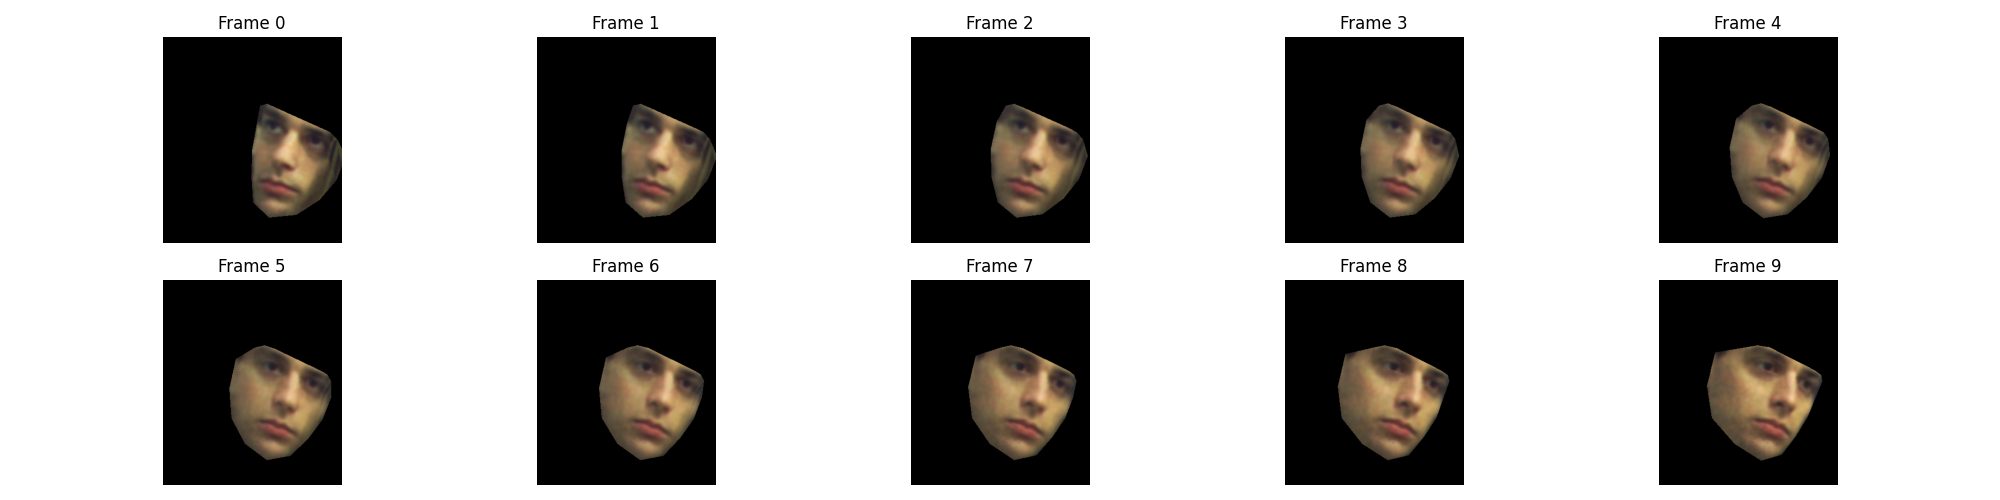

In [344]:
# Plot all frames
cols = 2
rows = len(frames) // cols
fig, axes = plt.subplots(cols, rows, figsize=(20, 5))
for i, frame in enumerate(frames):
    axes[i//rows, i%rows].imshow(frame)
    axes[i//rows, i%rows].set_title(f"Frame {i}")
    axes[i//rows, i%rows].axis('off')
plt.tight_layout()
plt.show()

#### **Expected Result** (It may  a little bit from run to run):<br>
![Correspondences](../data/morphing.png)

### 🔄 Step 5: Postwarp the Morphed Frames (2 Points)

In this final step, you'll apply a **postwarp transformation** to the morphed frames to bring them back to their original perspective. This step is necessary because the rectification process in Step 2 distorted the images to align the epipolar geometry. The postwarp step reverses this distortion, ensuring the morphed frames look natural in the original camera's perspective.

---

#### 👇 What You'll Do

1. **Apply the Inverse Rectification Homography**  
    Use the inverse of the rectification homography (`H1`) to warp each morphed frame back to the original perspective of the first image.

2. **Visualize the Postwarped Frames**  
    Display the postwarped frames to verify that the perspective has been restored.

---

💡 **Key Insight**:  
The postwarp step ensures that the final morphed images are not only geometrically accurate but also visually consistent with the original input images. Without this step, the morphed frames would appear distorted and unnatural.

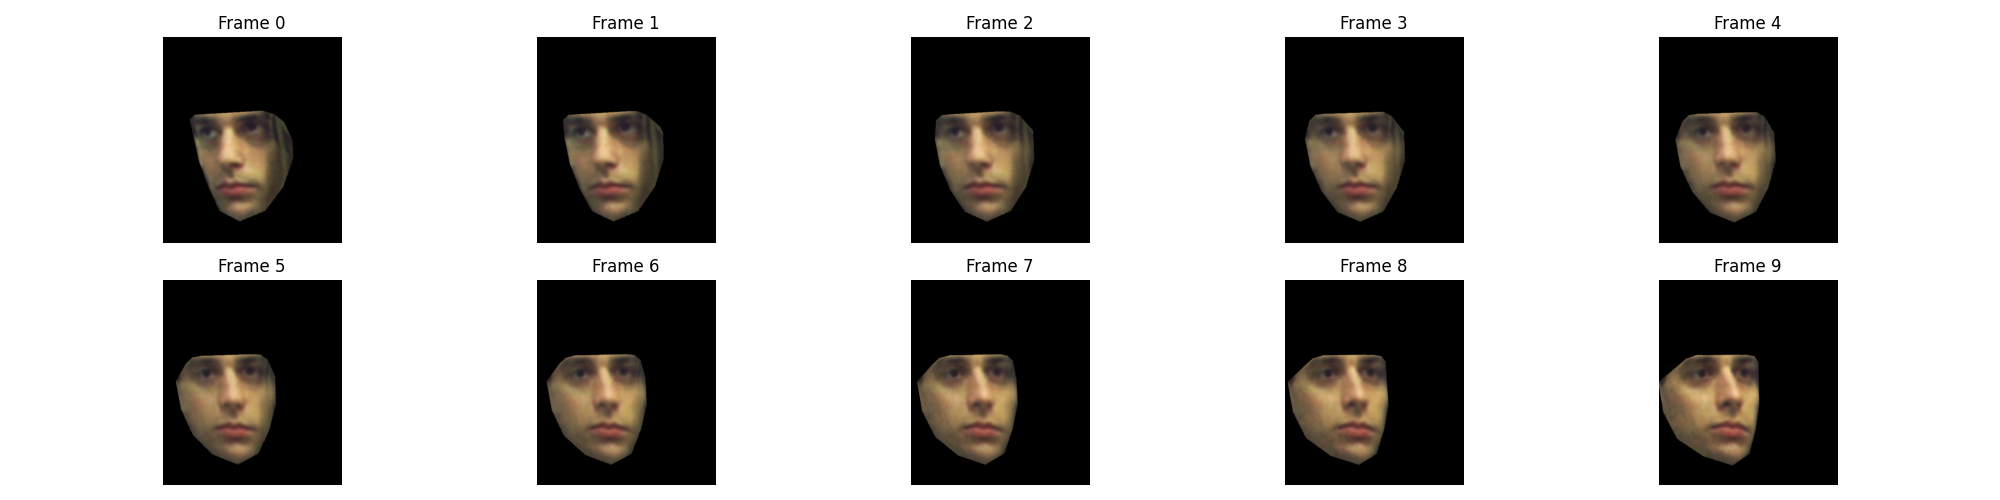

In [350]:
cols = 2
rows = len(frames) // cols
fig, axes = plt.subplots(cols, rows, figsize=(20, 5))
for i, frame in enumerate(frames):
    img_postwarped = cv2.warpPerspective(frame, np.linalg.inv(H1), (frame.shape[1], frame.shape[0]))
    axes[i//rows, i%rows].imshow(img_postwarped)
    axes[i//rows, i%rows].set_title(f"Frame {i}")
    axes[i//rows, i%rows].axis('off')
plt.tight_layout()
plt.show()

---

## 🏁 Conclusion

In this notebook, we explored the fascinating concepts of epipolar geometry, image rectification, and view morphing. By leveraging tools like Delaunay triangulation and affine transformations, we synthesized intermediate views between two images, creating a smooth morphing effect. This exercise not only demonstrated the power of computer vision techniques but also highlighted the importance of understanding the underlying geometry of images. By the end, we successfully reconstructed dense morphs and restored the original perspectives, achieving visually compelling results!
